# BMI/CS 576 Fall 2023 - HW2
The objectives of this homework are to practice

* implementing sequence alignment algorithms
* running dynamic programming algorithms for sequence alignment by hand
* working with probability

## HW policies
Before starting this homework, please read over the [homework policies](https://canvas.wisc.edu/courses/374201/pages/hw-policies) for this course.  In particular, note that homeworks are to be completed *individually* and plagiarism from any source (with the one exception noted below) will be considered **academic misconduct**.

You are welcome to use any code from the weekly notebooks (including the official solutions) in your solutions to the HW.

In [1]:
# Modules used in this HW
import random

import sequence_graph
import submatrix
import fasta

## PROBLEM 1: Sequence to graph alignment (50 points)

Some applications in computational biology require aligning a sequence to a set of closely related sequences.  For example, if we have sequencing data from a human of unknown ancestry, we may want to align the reads to the genomes of a diversity of indviduals, rather than one single reference genome. The representation of all known variation in the genomes of invididuals from a single species or clade is known as a "pangenome."  Research into computational methods that can operate on pangenomes is currently a hot topic in bioinformatics.

One way to compactly represent a set of closely related sequences is with a *sequence graph*.  A sequence graph is a directed acylic graph where each vertex is labeled by a character, with the exception of distinguished start and end vertices, which are unlabeled.  A sequence graph represents all sequences that can be formed by concatenating the characters along some path the starts at the start vertex and ends at the end vertex.  For example, the sequence graph below represents the following four sequences: CAG, CAT, TAG, TAT.

![bowtie](bowtie.png)

In this problem we will implement a dynamic programming algorithm for aligning a sequence, $x$, to a sequence graph, $g$. The advantage of this algorithm is that it can efficiently compare $x$ to all sequences represented by $g$, even if there are exponentially-many such sequences.

### The sequence to graph alignment task

Specifically, we will implement an algorithm that finds the highest-scoring global alignment between $x$ and any sequence that is represented by $g$. We will use a substitution matrix $S$ and a linear gap penalty function with space penalty $s$. The algorithm is similar to that for standard global alignment of two sequences with a linear gap penalty (i.e., Needleman–Wunsch alignment).

The subproblem, $M[i,j]$, for the dynamic programming algorithm is defined as the score of the highest-scoring alignment between the length $i$ prefix of $x$ and any sequence that is represented by a path in $g$ from the start vertex to vertex $j$.  Letting $n$ be the length of the sequence $x$ and $m + 1$ be the number of vertices in $g$, $M$ will be a matrix with $n + 1$ rows and $m + 1$ columns.  With the row and column indices starting at 0, the solution to the full problem is given by $M[n, m]$, with $m$ being the index of the end vertex in $g$.

#### main recurrences ($0 < i \leq n$ and $0 < j < m$)

$M(i, j) = \max\left\{
\begin{array}{l}
\max\limits_{k \in parents(j)} M(i - 1, k) + S(x_i, label(j)) \\
\max\limits_{k \in parents(j)} M(i, k) + s \\
M(i - 1, j) + s
\end{array}
\right.$

#### initialization

$M(0, 0) = 0$

first column ($0 < i \leq n$):

$M(i, 0) = M(i - 1, 0) + s$

first row, except for last entry ($0 < j < m$):

$M(0, j) = \max\limits_{k \in parents(j)} M(0, k) + s$

#### termination

last column ($0 < i \leq n$)

$M(i, m) = \max\limits_{k \in parents(m)} M(i, k)$

$\textrm{optimal alignment score} = M(n, m)$

#### traceback
Just like in Needleman–Wunsch alignment, the traceback procedure starts at entry $(n, m)$ and ends at $(0, 0)$.  At each step in the traceback, you should jump to the entry that gave rise to the maximum value in the recurrence.  Unlike Needleman–Wunsch, this may not be an entry that is immediately to the left, immediately above, or immediately to the upper-left of the current entry.

### assumptions and indexing
We will assume that the vertices of $g$ are in a topological order.  That is, for each vertex $j$, the index, $k$, of any parent of $j$ must have $k < j$.  Thus, just like in the Needleman–Wunsch algorithm, we can fill in the dynamic programming matrix row by row, from left to right, and be guaranteed that the entries we reference in the recurrence have already been computed.

*Important:* The algorithm is specified using 1-based indexing for the sequence $x$ (just like in Needleman–Wunsch), so the indices of $x$ go from 1 to $n$.  On the other hand, the vertices of the graph $g$ are numbered starting at 0.  The vertex indices go from 0 to $m$.  Since the vertices are in topological order, vertex 0 must be the start vertex and vertex $m$ must be the end vertex.  The only vertex with indegree = 0 is the start vertex and the only vertex with outdegree = 0 is the end vertex.

### tiebreaking
In the case that there are multiple optimal alignments, during the traceback, if there are ties for which case of the recurrence gives the maximum, use the case that traces back to a cell with coordinates that are *lexicographically largest*.  For example, if a cell has traceback pointers to cells $(i, j)$, and $(k, l)$, traceback to $(i, j)$ if $(i, j) > (k, l)$ and to $(k, l)$ if $(k, l) > (i, j)$.

### alignment representation
One complication in representing an alignment in this task is that some of the vertices of the graph may not participate in the alignment.  That is, if a vertex is not on the path through the graph that corresponded to the sequence with the highest-scoring alignment to $x$, then it will not have been explicitly aligned (either to a position in $x$ or a gap).  Nevertheless, we will include all vertices of $g$ in the alignment representation in topological order, and those that are not explicitly aligned will be matched against whitespace ' '.  For example, the two optimal alignments of AT to the example sequence graph above with match = +1, mismatch = -1, and $s = -1$ are

     -A T
    CTAGT

and

    - A T
    CTAGT
    
both of which have score = 1.  They represent aligning AT to the path in $g$ that spells TAT (first alignment) or CAT (second alignment).  The tiebreaking criterion specified above would result in the first alignment being chosen, assuming the topological ordering of the vertices gives the string CTAGT.

### Your task
Implement the algorithm described above as a function `align_sequence_to_graph` below, that takes as input a sequence, `x`, a SequenceGraph object, `g`, a substitution matrix, `substitution_matrix`, and a space score ($s$).  The substitution matrix will be represented as a dictionary with two-element tuples, `(a, b)`, as keys and scores as values.  Your function should output a tuple of two elements, the first being the score of an optimal alignment, and the second being a single alignment that obtains that score. Your alignment should be represented as a list of two strings.  See the "Tests for PROBLEM 1" section at the bottom of this notebook for examples of the inputs and outputs. 

Your implementation must use an efficient (polynomial-time) dynamic programming algorithm (i.e., either top-down or bottom-up)

In [2]:
# Here will set up some of the substitution matrices used in this homework
DNA = "ACGT"

# A simple match=+1 and mismatch=-1 substitution matrix for DNA
basic_dna_submatrix = submatrix.match_mismatch_matrix(1, -1, DNA)

print("basic_dna_submatrix:")
submatrix.print_matrix(basic_dna_submatrix)

# The BLOSUM62 amino acid substitution matrix
blosum62 = submatrix.read_substitution_matrix("BLOSUM62.txt")

basic_dna_submatrix:
       A   C   G   T
   A   1  -1  -1  -1
   C  -1   1  -1  -1
   G  -1  -1   1  -1
   T  -1  -1  -1   1


In [3]:
from math import inf


def align_sequence_to_graph(x, g, substitution_matrix, s):
    """Computes a global pairwise alignment of a sequence to a sequence graph
    
    Uses a linear gap scoring function with space score s.
    The graph is assumed to be in topological order, i.e., if vertex j is a parent of vertex i, then j < i
    In the case of ties during the traceback, the algorithm will traceback to the cell (i, j) in
    the dynamic programming matrix with the largest coordinates.
    
    Args:
        x: a sequence (represented as a string).
        g: a sequence graph (a SequenceGraph object).
        substitution_matrix: the substitution matrix, represented as a dictionary 
        s: the space score (a numeric value)
    Returns:
        A tuple (score, alignment), where alignment is represented
        as a list two aligned strings of the same length.
    """
    assert g.is_valid(), "sequence graph is not valid"

    M = {}
    T = {}
    M[0,0] = 0
    #First column
    for i in range(1, len(x) + 1):
        M[i,0] = M[i-1,0] + s
        T[i,0] = (i-1,0)
        
    #First row
    for j in range(1, g.num_vertices()-1):
        maximum = -inf
        for k in g.parents(j):
            temp = maximum
            maximum = max(maximum, M[0,k] +s)
            if temp != maximum:
                M[0,j] = maximum
                T[0,j] = (0,k)
    
    #All the columns and rows
    for i in range(1, len(x)+1):
        for j in range(1, g.num_vertices()-1):
            num1, temp1 = max(((M[i-1,k] + substitution_matrix[x[i-1],g.vertex_label(j)]), (i-1,k)) for k in g.parents(j))
            num2, temp2 = max(((M[i,k] + s),(i,k)) for k in g.parents(j))
            num3, temp3 = max(((M[i-1,j] + s), (i-1,j)) for k in g.parents(j))
            M[i,j],T[i,j] = max((num1,temp1), (num2,temp2), (num3,temp3))
    
    #Last column            
    for i in range(1, len(x) + 1):
        M[i, g.num_vertices()-1], T[i, g.num_vertices()-1] = max(((M[i,k]),(i,k)) for k in g.parents(g.num_vertices()-1))
                
    # print(x)
    #Traceback
    i = len(x)
    j = g.num_vertices() - 1
    
    alignment_x, alignment_g = [], []
    
    while i > 0 or j > 0:
        # print(i,j)
        # print(alignment_x, alignment_g)
        m, n = T[i,j]
        if i == 0 or (j > 0 and T[i, j] == ((i, j - 1))):
            if j - n > 1:
                alignment_x.append('-')
                alignment_g.append(g.vertex_label(j))
                memory = []
                for jj in range(n+1, j):
                    # print("E",g.vertex_label(jj))
                    alignment_x.append(' ')
                    memory.append(g.vertex_label(jj))
                memory.reverse()
                for mem in memory:
                    alignment_g.append(mem)
                j = g.parents(j)[0]
            elif g.vertex_label(j) == None:
                # print(g.parents(j))
                j = sorted(g.parents(j), reverse= True)
                j = j[0]
            else:
                alignment_x.append('-')
                alignment_g.append(g.vertex_label(j))
                j = g.parents(j)[0]
        elif i > 0 and (j == 0 or T[i, j] == ((i - 1, j))):
            alignment_x.append(x[i - 1])
            alignment_g.append('-')
            i -= 1
        elif T[i,j] == ((i-1, j-1)):
            alignment_x.append(x[i - 1])
            alignment_g.append(g.vertex_label(j))
            i -= 1
            j = g.parents(j)[0]
        elif j - n > 1:
            # print("IM")
            if g.vertex_label(j) != None:
                alignment_x.append(x[i - 1])
                alignment_g.append(g.vertex_label(j))
            memory = []
            for jj in range(n+1, j):
                # print("E",g.vertex_label(jj))
                alignment_x.append(' ')
                memory.append(g.vertex_label(jj))
            memory.reverse()
            for mem in memory:
                alignment_g.append(mem)
            i = m
            j = n
        else:
            if m == i-1:
                alignment_x.append(" ")
                alignment_g.append(g.vertex_label(j-1))
                i = m
                j = n
            elif j == j-1:
                alignment_x.append(x[i - 1])
                alignment_g.append(" ")
                i = m
                j = n

    # print(alignment_x, alignment_g)

    alignment_x = alignment_x[::-1]
    alignment_g = alignment_g[::-1]
    
    final_alignment = [''.join(alignment_x), ''.join(alignment_g)]
    # print(M[len(x),g.num_vertices()-2])
    # print(final_alignment)
    return ((M[len(x),g.num_vertices()-1], final_alignment))
    
# Some helper functions that may be of use to you in your implementation
def matrix(num_rows, num_cols, initial_value=None):
    """Returns a matrix (a list of rows, each of which is a list) 
    with num_rows and num_cols and with initial_value in each entry"""
    return [[initial_value] * num_cols for i in range(num_rows)]

def transpose_alignment(alignment):
    """Returns a column-based alignment from a row-based alignment or vice versa"""
    return list(map(''.join, zip(*alignment)))

Tests for `align_sequence_to_graph` are provided at the bottom of this notebook.

## PROBLEM 2: A SARS-CoV-2 recombinant (10 POINTS)

### Background: recombination
An important phenomenon in the evolution of genomes is that of *recombination*.  In general, recombination is a process in which a new "child" genomic sequence is created from a mixture of two more "parental" genomic sequences.  In humans, recombination regularly occurs during meiosis via a mechanism called "crossing over."  During a crossing over event in humans, the two homologous copies of a chromosome (one from dad and the other from mom) in a cell can exchange homologous parts.  For example, if the two homologous parental chromosomes are

    MMMMMMMMMMMMMMMMMMMMMMMMMMM

and

    DDDDDDDDDDDDDDDDDDDDDDDDDDD

then, for example, after one crossing over event, you can get a new chromosome that looks like

    MMMMMMMMDDDDDDDDDDDDDDDDDDD

or with two crossing over events you can get a chromosome looking like

    MMMMMMMMMMMMMMDDDDDDMMMMMMM

With further crossing over events, perhaps in later generations, chromosomes become complex mosaics of of the original parental chromosomes.  For a fun video illustrating this process in humans (via legos), see this [YouTube video from Science News](https://www.youtube.com/watch?v=RZWB_xt0chY).

### A SARS-CoV-2 recombinant

Recombination of various forms occurs across the tree of life, including in bacteria and viruses. In this problem, we will investigate the parental strains of a recombinant SARS-CoV-2 sequence.  Included in this HW is the sequence of the spike protein from a viral sample taken a from human during the pandemic.  This sequence is in the file `mystery.fasta`.  Also included in this HW is the original reference strain's sequence for the spike protein (`spike_reference.fasta`), as well as a table of the amino acid mutations present in this protein for four variants (`variant_mutations.txt`).  There are two columns in this mutation table, the first giving the variant name (e.g., delta) and the second giving the mutation represented as a string that is formed by concatenating the reference amino acid that is substituted, the position of that amino acid in the reference sequence, and the mutant amino acid.  For example, the mutation string "P681H" represents a mutation from 'P' to 'H' at position 681.

**(a)** Construct a SequenceGraph object that represents the reference spike protein sequence and all of the mutations provided in the table.  You should use the `VariantGraph` class in the `sequence_graph` module for this purpose, and add each mutation, one by one, via the `add_substitution_variant` method, providing the identity of the strain for each mutation.  Be sure to run the `reorder_topological` method after adding all mutations before proceeding to part (b). You may find it helpful to examine how the sequence graphs are constructed for the tests in problem 1.

**(b)** Use your `align_sequence_to_graph` function to align the mystery spike sequence to your SequenceGraph object from part (a) using the BLOSUM62 substitution matrix and space score = -5.  Use this alignment to determine the parental strain(s) for this sequence. You will need to use the `vertex_origin` method of the `VariantGraph` class to identify the parental origin of each vertex of the graph that is aligned to the mystery sequence.

*Note: if you are not successful in implementing the `align_sequence_to_graph` function in problem 1, you may use some other simpler means of identifying the parental strains, e.g., by looking for each of the mutations in the provided table.*

In [4]:
# a helper function for parsing the mutation strings in the mutation table file
def parse_mutation(mutation_string):
    """Parses a mutation string into a tuple (ref_aa, ref_position, mutant_aa)"""
    return (mutation_string[0], int(mutation_string[1:-1]), mutation_string[-1])

with open('spike_reference.fasta', 'r') as sFile:
    sFile = sFile.read()
    sFile = sFile.split('\n')
    reference_sequence = ''
    for i in range(1, len(sFile)):
        reference_sequence += sFile[i]

vGraph = sequence_graph.VariantGraph(reference_sequence)

with open('variant_mutations.txt', 'r') as mFile:
    for i in mFile:
        name, mutation = i.strip().split('\t')
        m1, m2, m3 = parse_mutation(mutation)
        vGraph.add_substitution_variant(m2, m3, name)       
vGraph.reorder_topological()


In [5]:
mystery = fasta.read_sequences_from_fasta_file("mystery.fasta")
mystery = mystery[0][1]
BLOSUM62 = submatrix.read_substitution_matrix("BLOSUM62.txt")

align = align_sequence_to_graph(mystery, vGraph, BLOSUM62, -5)

f = align[1][0]
s = align[1][1]
ver = []
countd = 0
for i in range(len(align[1][1])):
    if s[i] == '-':
        countd += 1
    if f[i] == ' ' or s[i] == '-':
        continue
    else:
        ver.append(vGraph.vertex_origin(i+1-countd))

ans = []
for j in set(ver):
    if j == 'alpha' or j == 'beta' or j == 'delta' or j == 'omicron':
        ans.append(j)
    
print(ans)

['omicron', 'alpha', 'delta']


## PROBLEM 3: Affine-gap local alignment by hand (20 POINTS)

By hand, compute *all* optimal __local__ alignments of the sequences `CACAGTA` and `CTAT` with an affine-gap penalty function and parameters 

* match = 4
* mismatch = -2
* gap = -1
* space = -1

Show your work in the form of filled out dynamic programming matrices and all traceback pointers.

## &lt;ANSWER&gt; ##

##### Largest Score = 9
##### ACAGTA
##### -C--TA

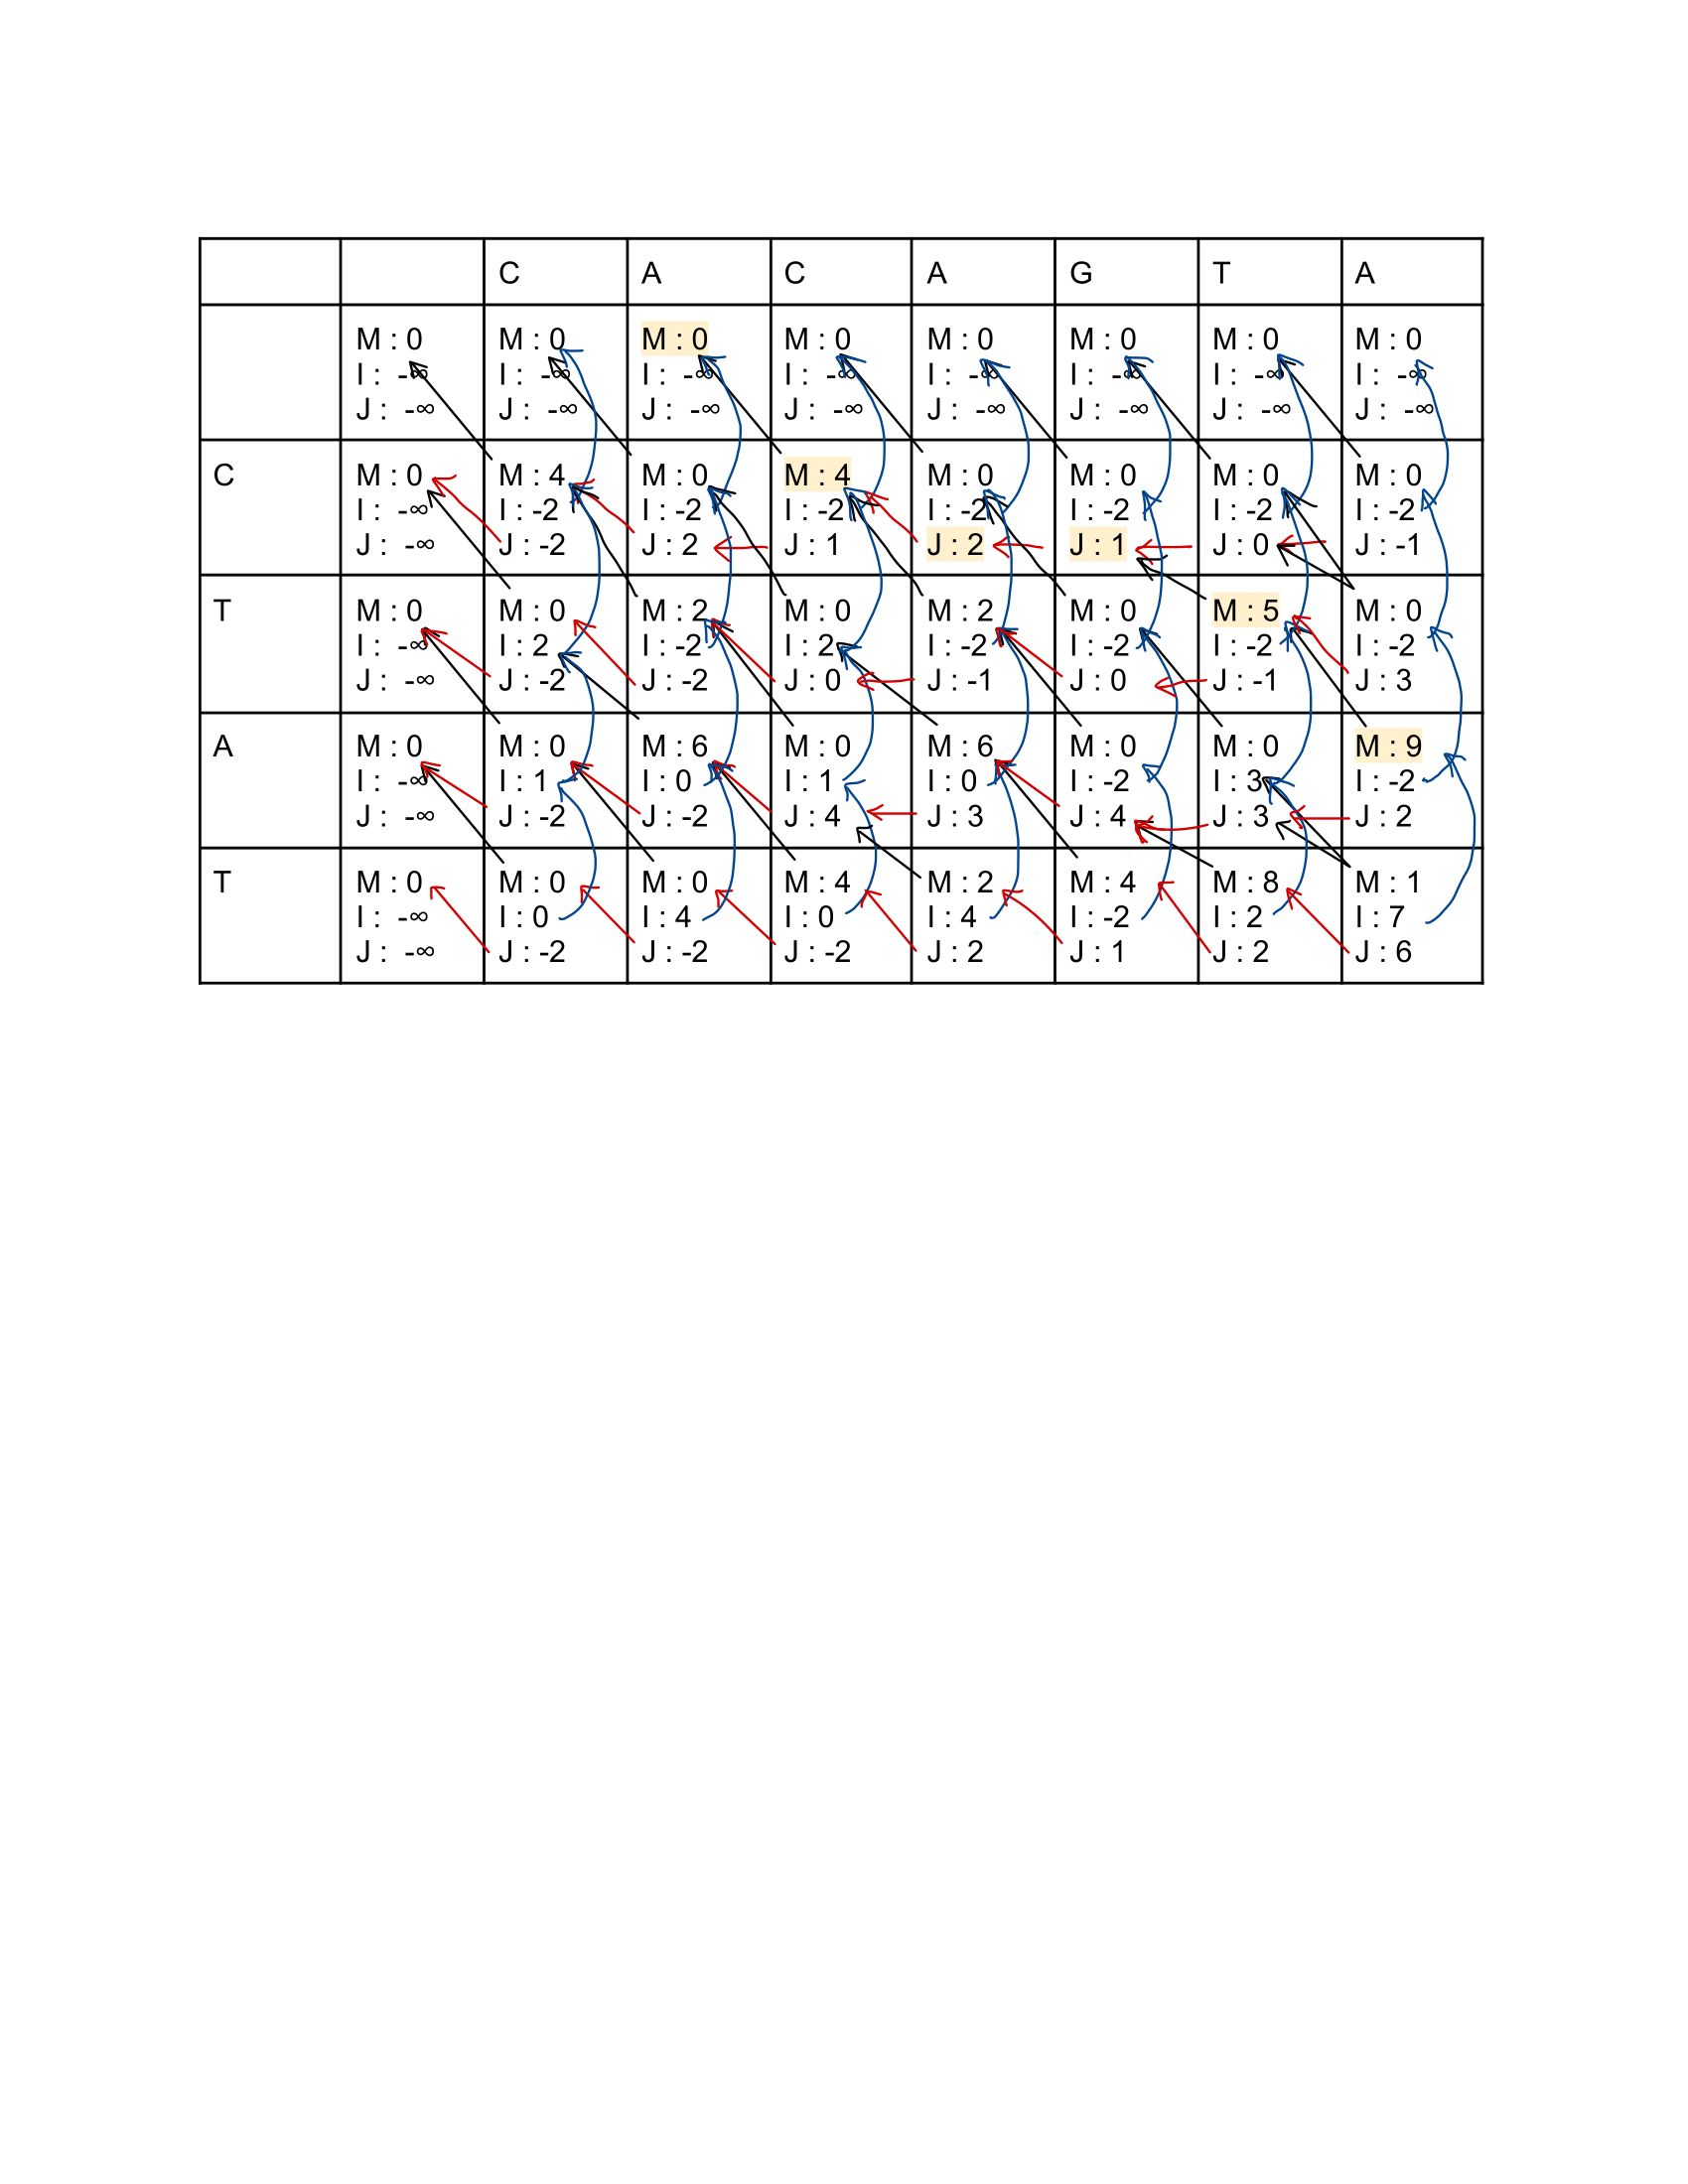

In [6]:
from IPython.display import Image

fig = Image(filename=('prob3.png'))
fig

###
### Your written solutions to PROBLEM 3
###


## PROBLEM 4: Sequence variant probabilities (20 POINTS)

strain | frequency (%) | sequence   |
---    | ---           | ---        |
1      | 40            | `ATCGTGGC` |
2      | 30            | `ATCATAGC` |
3      | 20            | `CTCATAGC` |
4      | 10            | `CTCGTGGC` |

Suppose there are four strains (1, 2, 3, and 4) of a virus circulating in the population with frequencies and (very short) genome sequences given in the table above.  Suppose we randomly sample a single virus from this population, which we assume to be infinitely large.  Let $S$ be the random variable representing the strain of this virus and $X_1, X_2, \ldots, X_8$ be random variables representing the eight characters of its genome sequence. Compute the following and *show your work*:

**(A)** $P(X_1 = A)$

**(B)** $P(X_4 = A)$

**(C)** $P(X_1 = A, X_4 = A)$

**(D)** $P(S = 3 | X_4 = A)$

Now suppose that we randomly sample $n = 5$ viruses from this population and are able to observe the complete sequence of each of these viruses, giving us a count for each strain.  Let $C_1$, $C_2$, $C_3$, and $C_4$ be random variables representing the counts for strains 1, 2, 3, and 4, respectively.  Compute the following and *show your work*:

**(E)** $P(C_1 = 2)$

**(F)** $E[C_1]$

**(G)** $P(C_1 = 2, C_2 = 1, C_3 = 1, C_4 = 1)$

###
### Your written solutions to PROBLEM 4
###


## &lt;ANSWER&gt; ##

(A) $P(X_1 = A)$ = $(P(X_1 = A|S = 1) \cdot P(S = 1))$ + $(P(X_1 = A|S = 2) \cdot P(S = 2))$ + $(P(X_1 = A|S = 3) \cdot P(S = 3))$ + $(P(X_1 = A|S = 4) \cdot P(S = 4))$ = $1 \cdot 0.40 + 1 \cdot 0.30 + 0 \cdot 0.20 + 0 \cdot 0.10 = 0.40 + 0.30 = 0.7$ -> 70%

(B) $P(X_4 = A)$ = $(P(X_4 = A|S = 1) \cdot P(S = 1))$ + $(P(X_4 = A|S = 2) \cdot P(S = 2))$ + $(P(X_4 = A|S = 3) \cdot P(S = 3))$ + $(P(X_4 = A|S = 4) \cdot P(S = 4))$ = $0 \cdot 0.40 + 1 \cdot 0.30 + 1 \cdot 0.20 + 0 \cdot 0.10 = 0.30 + 0.20 = 0.5$ -> 50%

(C) $P(X_1, X_4 = A)$ = $(P(X_1 = A, X_4 = A|S = 1) \cdot P(S = 1))$ + $(P(X_1 = A, X_4 = A|S = 2) \cdot P(S = 2))$ + $(P(X_1 = A, X_4 = A|S = 3) \cdot P(S = 3))$ + $(P(X_1 = A, X_4 = A|S = 4) \cdot P(S = 4))$ = $1 \cdot 0 \cdot 0.40 + 1 \cdot 1 \cdot 0.30 + 0 \cdot 1 \cdot 0.20 + 0 \cdot 0 \cdot 0.10 = 0.3$ -> 30%

(D) $P(S = 3 | X_4 = A)$ = $(P(X_4 = A|S = 3) \cdot P(S = 3)) /  P(X_4 = A)$ = $(1 \cdot 0.20) / 0.5 = 0.4$ -> 40%

(E) $P(C_1 = 2)$ = $(n k) \cdot p^k \cdot (1-p)^{n-k} $ = $(5 2) \cdot (0.40)^2 \cdot (1-0.40)^{5-2}$ = $ (5 \cdot 4)/ (2 \cdot 1) \cdot 0.16 \cdot 0.216 = 10 \cdot 0.16 \cdot 0.216 = 0.3456$ -> 34.56%

(F) $E[C_1]$ = $\sum_{c1} c1 \cdot P(C1 = c1)$ = $0 \cdot P(C1 = 0) + 1 \cdot P(C1 = 1) + 2 \cdot P(C1 = 2) + 3 \cdot P(C1 = 3) + 4 \cdot P(C1 = 4) + 5 \cdot P(C1 = 5)$ = $ 0 \cdot ((0.4)^0 \cdot (1-0.4)^5) + 1 \cdot (5 \cdot (0.4)^1 \cdot (1-0.4)^4) + 2 \cdot 0.3456 + 3 \cdot ((5 \cdot 4)/ 2 \cdot (0.4)^3 \cdot (1-0.4)^2) + 4 \cdot (5 \cdot (0.4)^4 \cdot (1-0.4)^1) + 5 \cdot ((0.4)^5 \cdot (1-0.4)^0)$ = $ 0 \cdot 0.07776 +  1 \cdot (5 \cdot 0.4 \cdot 0.1296) + 2 \cdot 0.3456 + 3 \cdot (10 \cdot 0.064 \cdot 0.36) + 4 \cdot (5 \cdot 0.0256 \cdot 0.6) + 5 \cdot 0.01024 = 2$

(G) $P(C_1 = 2, C_2 = 1, C_3 = 1, C_4 = 1)$ = $(5!/2!\cdot 1! \cdot 1! \cdot 1!) \cdot (0.4)^2 \cdot (0.3) \cdot(0.2) \cdot(0.1)$ = $60 \cdot 0.00096 = 0.0576$ -> 5.76%

## Tests for PROBLEM 1

## Sequence graphs for testing

In [7]:
linear_g = sequence_graph.VariantGraph("CAT")
linear_g.plot()

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="420.0px" height="180.0px" viewBox="0 0 420.0 180.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t87a6dec7287b406a9dadc25e6a9389e2"> C A T

In [8]:
long_linear_g = sequence_graph.VariantGraph("TCTTTGCAG")
long_linear_g.plot()

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="900.0px" height="180.0px" viewBox="0 0 900.0 180.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t0937393c937043378a78345af2e6f87a"> T C T T T G C A G

In [9]:
diamond_g = sequence_graph.VariantGraph("ACT")
diamond_g.add_substitution_variant(2, "G")
diamond_g.reorder_topological()
diamond_g.plot()

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="420.0px" height="260.0px" viewBox="0 0 420.0 260.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tc1f2167014e1455ca2fe98a210184ee5"> A G C T

In [10]:
fork_g = sequence_graph.VariantGraph("CA")
fork_g.add_substitution_variant(2, "G")
fork_g.add_substitution_variant(2, "T")
fork_g.reorder_topological()
fork_g.plot()

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="340.0px" height="340.0px" viewBox="0 0 340.0 340.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t08eb4c48fb634d1a90674dbf397f25f1"> C T G A

In [11]:
merge_g = sequence_graph.VariantGraph("RK")
merge_g.add_substitution_variant(1, "S")
merge_g.add_substitution_variant(1, "V")
merge_g.reorder_topological()
merge_g.plot()

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="340.0px" height="340.0px" viewBox="0 0 340.0 340.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t9303b670da114086a6b085947aabf823"> V S R K

In [12]:
bowtie_g = sequence_graph.VariantGraph("TAT")
bowtie_g.add_substitution_variant(1, "C")
bowtie_g.add_substitution_variant(3, "G")
bowtie_g.reorder_topological()
bowtie_g.plot()

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="420.0px" height="260.0px" viewBox="0 0 420.0 260.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t292d4f70c06b4f1fbf7453123160d07d"> C T A G T

In [13]:
unmerged_g = sequence_graph.VariantGraph("CA")
unmerged_g.add_complex_variant(1, 2, "AG")
unmerged_g.reorder_topological()
unmerged_g.plot()

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="340.0px" height="260.0px" viewBox="0 0 340.0 260.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t3db27895aacb4a31a9bdf12ca39fc3bc"> A G C A

In [14]:
random.seed(5)
random1_g = sequence_graph.random_sequence_graph(5)
random1_g.plot(curved_edges=True)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="260.0px" viewBox="0 0 500.0 260.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tfe197f63d536447489305d863b9caaeb"> C A C T C

In [15]:
random.seed(39)
random2_g = sequence_graph.random_sequence_graph(10, edge_prob=0.2)
random2_g.plot(curved_edges=True)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="580.0px" height="420.0px" viewBox="0 0 580.0 420.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t4cd1fd4c83464f6bb2a8ea4a3746d03f"> C C C A T G G C C C

###  Test cases and testing functions

In [16]:
test_case_inputs = {
    'linear_1':    (     "CAT",      linear_g, basic_dna_submatrix, -1),
    'linear_2':    (      "AT",      linear_g, basic_dna_submatrix, -1),
    'linear_3':    (   "ACATA",      linear_g, basic_dna_submatrix, -1),
    'linear_4':    (       "A",      linear_g, basic_dna_submatrix, -1),
    'linear_5':    (    "CAAT",      linear_g, basic_dna_submatrix, -1),
    'long_linear': ("TTGCACGG", long_linear_g, basic_dna_submatrix, -1),
    'diamond':     (     "AGT",     diamond_g, basic_dna_submatrix, -1),
    'fork':        (     "TTT",        fork_g, basic_dna_submatrix, -1),
    'merge':       (      "SK",       merge_g, blosum62,            -1),
    'bowtie':      (      "AT",      bowtie_g, basic_dna_submatrix, -1),
    'unmerged':    (    "TAGA",    unmerged_g, basic_dna_submatrix, -2),
    'random1':     (    "GCAC",     random1_g, basic_dna_submatrix, -1),
    'random2':     (   "CCAGC",     random2_g, basic_dna_submatrix, -1)
}

test_case_correct_outputs = {
    'linear_1':    ( 3, ['CAT', 
                         'CAT']),
    'linear_2':    ( 1, ['-AT', 
                         'CAT']),
    'linear_3':    ( 1, ['ACATA', 
                         '-CAT-']),
    'linear_4':    (-1, ['-A-', 
                          'CAT']),
    'linear_5':    ( 2, ['CAAT', 
                         'CA-T']),
    'long_linear': ( 1, ['T-T--GCACGG',
                         'TCTTTGCA-G-']),
    'diamond':     ( 3, ['AG T', 
                         'AGCT']),
    'fork':        (-1, ['TTT  ', 
                         'CT-GA']), 
    'merge':       ( 9, [' S K', 
                         'VSRK']),
    'bowtie':      ( 1, [' -A T', 
                         'CTAGT']),     
    'unmerged':    (-2, ['TAGA  ', 
                         '-AG-CA']),
    'random1':     ( 2, ['GCA  C', 
                         '-CACTC']),
    'random2':     ( 3, ['CC  A G   C', 
                         'C-CCATGGCCC'])
}

import numbers
import io
import sys

def remove_gaps(s):
    """Returns a string with '-' and ' ' characters removed"""
    return s.replace('-', '').replace(' ', '')

def check_valid_alignment_result(result, x, g):
    """Checks that the alignment result is valid for x and g.""" 
    assert isinstance(result, tuple), "Output is not a tuple"
    assert len(result) == 2, "Output does not have exactly two elements"
    
    score, alignment = result
    assert isinstance(alignment, list), "Alignment is not a list"
    assert isinstance(score, numbers.Number), "Score is not a number"
    
    assert len(alignment) == 2, "Alignment does not have exactly two elements"
    assert all(isinstance(element, str) for element in alignment), "Alignment elements are not strings"
    num_columns = len(alignment[0])
    assert all(len(row) == num_columns for row in alignment), "Alignment strings do not have the same length"
    
    assert remove_gaps(alignment[0]) == x, "First string of alignment is not x"
    assert remove_gaps(alignment[1]) == g.topological_string(), "Second string of alignment is not characters of g in topological order"

def check_test_case(case_name, test_name=None, valid_result=True, correct_alignment=True):
    inputs = test_case_inputs[case_name]
    correct_output = test_case_correct_outputs[case_name]
    result = align_sequence_to_graph(*inputs)
    if valid_result:
        check_valid_alignment_result(result, *inputs[:2])
    if correct_alignment:
        error_message = io.StringIO()
        print("Incorrect output", file=error_message)
        print("your function returned:", file=error_message)
        pprint_align(result, stream=error_message)
        print(file=error_message)
        print("the correct output is:", file=error_message)
        pprint_align(correct_output, stream=error_message)
        assert result == correct_output, error_message.getvalue()

    print("SUCCESS:", test_name if test_name else case_name, "passed!")

def pprint_align(align_result, stream=sys.stdout):
    """Pretty prints the result of align_sequence_to_graph.
    
    Args:
        align_result: an output from align_sequence_to_graph
        stream: the stream (a file-like object) to which to print
    """
    score, alignment = align_result
    print(f"    Score: {score}", file=stream)
    print(f"Alignment:", file=stream)
    print(f"        x: {alignment[0]}", file=stream)
    print(f"        g: {alignment[1]}", file=stream)

### Visible tests

In [17]:
# TEST: linear_valid output (4 POINTS)
check_test_case("linear_1", test_name="linear valid output", valid_result=True, correct_alignment=False)

SUCCESS: linear valid output passed!


In [18]:
# TEST: linear_1 correct (4 POINTS)
check_test_case("linear_1", test_name="linear correct")

SUCCESS: linear correct passed!


In [19]:
# TEST: linear_2 (4 POINTS)
check_test_case("linear_2")

SUCCESS: linear_2 passed!


In [20]:
# TEST: linear_3 (4 POINTS)
check_test_case("linear_3")

SUCCESS: linear_3 passed!


In [21]:
# TEST: linear_4 (4 POINTS)
check_test_case("linear_4")

SUCCESS: linear_4 passed!


In [22]:
# TEST: linear_5 (4 POINTS)
check_test_case("linear_5")

SUCCESS: linear_5 passed!


In [23]:
# TEST: long_linear (2 POINTS)
check_test_case("long_linear")

SUCCESS: long_linear passed!


In [24]:
# TEST: diamond (2 POINTS)
check_test_case("diamond")

SUCCESS: diamond passed!


In [25]:
# TEST: fork (2 POINTS)
check_test_case("fork")

SUCCESS: fork passed!


In [26]:
# TEST: merge (2 POINTS)
check_test_case("merge")

SUCCESS: merge passed!


In [27]:
# TEST: bowtie (2 POINTS)
check_test_case("bowtie")

SUCCESS: bowtie passed!


In [28]:
# TEST: unmerged (2 POINTS)
check_test_case("unmerged")

SUCCESS: unmerged passed!


In [29]:
# TEST: random1 (2 POINTS)
check_test_case("random1")

SUCCESS: random1 passed!


In [30]:
# TEST: random2 (2 POINTS)
check_test_case("random2")

SUCCESS: random2 passed!


### Hidden tests

In [31]:
# TEST: hidden_1 (2 POINTS)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [32]:
# TEST: hidden_2 (2 POINTS)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [33]:
# TEST: hidden_3 (2 POINTS)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [34]:
# TEST: hidden_4 (2 POINTS)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [35]:
# TEST: hidden_5 (2 POINTS)
###
### AUTOGRADER TEST - DO NOT REMOVE
###
